In [1]:
from dbConn import engine
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
base_query = '''
SELECT 
    spx.Datetime,
    spx.Open AS Open_SPX,
    spx.High AS High_SPX,
    spx.Low AS Low_SPX,
    spx.Close AS Close_SPX,
    ndx.Open AS Open_NDX,
    ndx.High AS High_NDX,
    ndx.Low AS Low_NDX,
    ndx.Close AS Close_NDX,
    rut.Open AS Open_RUT,
    rut.High AS High_RUT,
    rut.Low AS Low_RUT,
    rut.Close AS Close_RUT
    FROM (
    SELECT * FROM SPX_full_5min
    ) spx
    JOIN (
    SELECT * FROM NDX_full_5min
    ) ndx ON spx.Datetime = ndx.Datetime
    LEFT JOIN (
    SELECT * FROM RUT_full_5min
    ) rut ON spx.Datetime = rut.Datetime
-- WHERE spx.Datetime >= '2018-01-01'
'''

# Initialize variables for pagination
offset = 0
limit = 50000
data_frames = []

while True:
    # Construct the query with LIMIT and OFFSET
    query = f"{base_query} LIMIT {limit} OFFSET {offset}"
    
    # Fetch the chunk of data
    df_chunk = pd.read_sql_query(query, con = engine.connect())
    
    # Break the loop if no more data is returned
    if df_chunk.empty:
        break

    # Append the chunk to the list of dataframes
    data_frames.append(df_chunk)

    # Update the offset for the next query
    offset += limit

# Concatenate all dataframes
data = pd.concat(data_frames, ignore_index=True)

In [3]:
len(data)

331276

In [4]:
data.head()

,Datetime,Open_SPX,High_SPX,Low_SPX,Close_SPX,Open_NDX,High_NDX,Low_NDX,Close_NDX,Open_RUT,High_RUT,Low_RUT,Close_RUT
0,2007-04-27 12:20:00,1492.19,1492.40,1492.19,1492.38,1887.90,1887.91,1886.97,1887.65,829.54,829.55,829.35,829.41
1,2007-04-27 12:25:00,1492.39,1492.91,1492.39,1492.87,1887.72,1888.32,1887.72,1888.27,829.42,829.68,829.42,829.68
2,2007-04-27 12:30:00,1492.54,1492.80,1492.53,1492.58,1887.77,1888.68,1887.65,1888.13,829.65,829.84,829.65,829.73
3,2007-04-27 12:35:00,1492.70,1492.88,1492.30,1492.88,1888.09,1888.24,1887.27,1888.24,829.65,829.65,829.25,829.38
4,2007-04-27 12:40:00,1492.88,1494.46,1492.88,1493.94,1888.26,1890.01,1888.26,1889.31,829.39,830.08,829.39,830.03


In [5]:
data['Date'] = data['Datetime'].dt.date
data['Time'] = data['Datetime'].dt.time

In [6]:
data['Datetime'].min()

Timestamp('2007-04-27 12:20:00')

In [7]:
data['Datetime'].max()

Timestamp('2024-01-12 16:00:00')

In [8]:
import datetime

# Start Run Models

In [115]:
ticker_dict = {
    "^GSPC":{
        "hod_model":"models/hod_model_spx.joblib",
        "lod_model":"models/lod_model_spx.joblib",
        "gd_model":"models/gd_model_spx.joblib",
        "suffix":"SPX"
    },
    "^NDX":{
        "hod_model":"models/hod_model_ndx.joblib",
        "lod_model":"models/lod_model_ndx.joblib",
        "gd_model":"models/gd_model_ndx.joblib",
        "suffix":"NDX"
    },
    "^RUT":{
        "hod_model":"models/hod_model_rut.joblib",
        "lod_model":"models/lod_model_rut.joblib",
        "gd_model":"models/gd_model_rut.joblib",
        "suffix":"RUT"
    }
}

tck = '^RUT'

spx_data = data.loc[:,[
    'Datetime',
    f'Open_{ticker_dict[tck]["suffix"]}',
    f'High_{ticker_dict[tck]["suffix"]}',
    f'Low_{ticker_dict[tck]["suffix"]}',
    f'Close_{ticker_dict[tck]["suffix"]}'
]]
spx_data.columns = ['Datetime','open','high','low','close']
spx_data['time'] = spx_data['Datetime'].dt.time
spx_data = spx_data.loc[(spx_data['time'] < datetime.time(16,0)) & (spx_data['time'] >= datetime.time(9,30))]

In [116]:
spx_data = spx_data.set_index('Datetime')

In [117]:
# Create a list of times from 9:30 to 15:55 with 5 minute intervals
times = pd.date_range(start="9:30", end="15:55", freq='5min').time

# Create a dictionary that maps each time to a unique integer
time_to_int = {time: i+1 for i, time in enumerate(times)}

# Assume df is your DataFrame and 'time' is your column of times
spx_data['bar_num'] = spx_data['time'].map(time_to_int)

In [118]:
# Get the last bar of each date
spx_data['eod_close'] = spx_data.groupby(spx_data.index.date)['close'].tail(1)
spx_data['prev_close'] = spx_data['eod_close'].shift(1)
spx_data['prev_close'] = spx_data['prev_close'].ffill()
spx_data['eod_close'] = spx_data['eod_close'].bfill()
spx_data['green_day'] = spx_data['eod_close'] > spx_data['prev_close']

spx_data['eod_close_pts'] = spx_data['eod_close'] - spx_data['prev_close']
spx_data['eod_close_pct'] = spx_data['eod_close_pts'] / spx_data['prev_close']

In [119]:
spx_data.head()

,open,high,low,close,time,bar_num,eod_close,prev_close,green_day,eod_close_pts,eod_close_pct
Datetime,,,,,,,,,,,
2007-04-27 12:20:00,829.54,829.55,829.35,829.41,12:20:00,35,829.8,NaN,False,NaN,NaN
2007-04-27 12:25:00,829.42,829.68,829.42,829.68,12:25:00,36,829.8,NaN,False,NaN,NaN
2007-04-27 12:30:00,829.65,829.84,829.65,829.73,12:30:00,37,829.8,NaN,False,NaN,NaN
2007-04-27 12:35:00,829.65,829.65,829.25,829.38,12:35:00,38,829.8,NaN,False,NaN,NaN
2007-04-27 12:40:00,829.39,830.08,829.39,830.03,12:40:00,39,829.8,NaN,False,NaN,NaN


In [120]:
spx_data.tail()

,open,high,low,close,time,bar_num,eod_close,prev_close,green_day,eod_close_pts,eod_close_pct
Datetime,,,,,,,,,,,
2024-01-12 15:35:00,NaN,NaN,NaN,NaN,15:35:00,74,NaN,2027.75,False,NaN,NaN
2024-01-12 15:40:00,NaN,NaN,NaN,NaN,15:40:00,75,NaN,2027.75,False,NaN,NaN
2024-01-12 15:45:00,NaN,NaN,NaN,NaN,15:45:00,76,NaN,2027.75,False,NaN,NaN
2024-01-12 15:50:00,NaN,NaN,NaN,NaN,15:50:00,77,NaN,2027.75,False,NaN,NaN
2024-01-12 15:55:00,NaN,NaN,NaN,NaN,15:55:00,78,NaN,2027.75,False,NaN,NaN


# Feature and Target Creation
Target
- Whether the current high or low of the **session** has been achieved, based on the close of the most recent 5 min bar. 

Features
- Current and lagged features of each **session**.

In [121]:
import numpy as np
import pandas as pd
import datetime
from pandas.tseries.offsets import BDay
from tqdm import tqdm

spx_data['label'] = np.nan

# Per date, run it.
for day in tqdm(sorted(set(spx_data.index.date))):
    day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
    day_open = spx_data.loc[day_str, 'open'].iloc[0]
    spx_data.loc[day_str, 'lod'] = spx_data.loc[day_str, 'low'].min()
    spx_data.loc[day_str, 'label_lod'] = (spx_data.loc[day_str, 'low'] == spx_data.loc[day_str, 'lod']).astype(int)
    
    spx_data.loc[day_str, 'hod'] = spx_data.loc[day_str, 'high'].max()
    spx_data.loc[day_str, 'label'] = (spx_data.loc[day_str, 'high'] == spx_data.loc[day_str, 'hod']).astype(int)
    spx_data.loc[day_str, 'day_open'] = day_open
    spx_data.loc[day_str, 'day_open_pts'] = spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'day_open']
    spx_data.loc[day_str, 'day_open_pct'] = spx_data.loc[day_str, 'day_open_pts'] / spx_data.loc[day_str, 'day_open']
    spx_data.loc[day_str, 'prev_close_pts'] = spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'prev_close']
    spx_data.loc[day_str, 'prev_close_pct'] = spx_data.loc[day_str, 'prev_close_pts'] / spx_data.loc[day_str, 'prev_close']

    # Lowest low
    spx_data.loc[day_str, 'lowest_low'] = spx_data.loc[day_str, 'low'].expanding().min()
    spx_data.loc[day_str, 'lowest_low'] = spx_data.loc[day_str, 'lowest_low'].shift(1)
    spx_data.loc[day_str, 'lowest_low'] = spx_data.loc[day_str, 'lowest_low'].ffill()
    spx_data.loc[day_str, 'lowest_low_mag'] = (spx_data.loc[day_str, 'close'] / spx_data.loc[day_str, 'lowest_low']) - 1

    # Highest high
    spx_data.loc[day_str, 'highest_high'] = spx_data.loc[day_str, 'high'].expanding().max()
    spx_data.loc[day_str, 'highest_high'] = spx_data.loc[day_str, 'highest_high'].shift(1)
    spx_data.loc[day_str, 'highest_high'] = spx_data.loc[day_str, 'highest_high'].ffill()
    spx_data.loc[day_str, 'highest_high_mag'] = (spx_data.loc[day_str, 'close'] / spx_data.loc[day_str, 'highest_high']) - 1

    # Shifted
    spx_data.loc[day_str, 'prev_close_pct_n1'] = spx_data.loc[day_str, 'prev_close_pct'].shift(1)
    spx_data.loc[day_str, 'prev_close_pct_n2'] = spx_data.loc[day_str, 'prev_close_pct'].shift(2)
    spx_data.loc[day_str, 'prev_close_pct_n3'] = spx_data.loc[day_str, 'prev_close_pct'].shift(3)

    spx_data.loc[day_str, 'day_open_pct_n1'] = spx_data.loc[day_str, 'day_open_pct'].shift(1)
    spx_data.loc[day_str, 'day_open_pct_n2'] = spx_data.loc[day_str, 'day_open_pct'].shift(2)
    spx_data.loc[day_str, 'day_open_pct_n3'] = spx_data.loc[day_str, 'day_open_pct'].shift(3)

    # New Features
    spx_data.loc[day_str, 'open_slope'] = spx_data.loc[day_str, 'day_open_pct'] / spx_data.loc[day_str, 'bar_num']
    spx_data.loc[day_str, 'daily_slope'] = spx_data.loc[day_str, 'prev_close_pct'] / spx_data.loc[day_str, 'bar_num']
    spx_data.loc[day_str, 'highest_high_slope'] = (spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'highest_high']) / spx_data.loc[day_str, 'bar_num']
    spx_data.loc[day_str, 'lowest_low_slope'] = (spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'lowest_low']) / spx_data.loc[day_str, 'bar_num']
    

    # Label the data: 1 if the current high is the HOD, 0 otherwise

    # # Find the index of HOD
    # hod_index = spx_data.loc[day_str][spx_data.loc[day_str, 'label'] == 1].index

    # # If HOD is found within the first 5 bars, label the first 5 bars as 1
    # if not hod_index.empty:
    #     hod_index = hod_index[0]  # In case there are multiple, take the first
    #     if hod_index <= spx_data.loc[day_str].index[4]:  # Check if HOD is within the first 5 bars
    #         spx_data.loc[spx_data.loc[day_str].index[:5], 'label'] = 1
    #     else:
    #         start_time = spx_data.loc[day_str].index[0]
    #         end_time = hod_index
    #         # Calculate the start index using Timedelta
    #         start_index = end_time - pd.Timedelta(minutes=5 * 4)
    #         start_index = max(start_index, start_time)
    #         spx_data.loc[start_index:end_time, 'label'] = 1

# spx_data.head()


  0%|          | 0/4207 [00:00<?, ?it/s]

100%|██████████| 4207/4207 [02:07<00:00, 32.93it/s]


In [122]:
spx_data.isnull().sum()

open                    803
high                    803
low                     803
close                   803
time                      0
bar_num                   0
eod_close               702
prev_close               44
green_day                 0
eod_close_pts           746
eod_close_pct           746
label                     0
lod                     702
label_lod                 0
hod                     702
day_open               1373
day_open_pts           1419
day_open_pct           1419
prev_close_pts          847
prev_close_pct          847
lowest_low             4955
lowest_low_mag         5001
highest_high           4955
highest_high_mag       5001
prev_close_pct_n1      5025
prev_close_pct_n2      9213
prev_close_pct_n3     13407
day_open_pct_n1        5589
day_open_pct_n2        9769
day_open_pct_n3       13955
open_slope             1419
daily_slope             847
highest_high_slope     5001
lowest_low_slope       5001
dtype: int64

In [123]:
spx_data['gap_open'] = spx_data['day_open'] - spx_data['prev_close']
spx_data['gap_open_pct'] = spx_data['gap_open'] / spx_data['prev_close']

In [124]:
hod_in = []
for num, row in tqdm(spx_data.iterrows()):
    if row['hod'] == row['high']:
        hod_in.append(1)
    else:
        hod_in.append(np.nan)
spx_data['hod_in'] = hod_in

327034it [00:09, 34241.22it/s]


In [125]:
lod_in = []
for num, row in tqdm(spx_data.iterrows()):
    if row['lod'] == row['low']:
        lod_in.append(1)
    else:
        lod_in.append(np.nan)
spx_data['lod_in'] = lod_in

327034it [00:09, 33815.22it/s]


In [126]:
# Per day, ffill for the 1s, and then fillna 0
for day in tqdm(sorted(set(spx_data.index.date))):
    day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
    spx_data.loc[day_str, 'lod_in'] = spx_data.loc[day_str, 'lod_in'].ffill()
    spx_data.loc[day_str, 'lod_in'] = spx_data.loc[day_str, 'lod_in'].fillna(0)
    spx_data.loc[day_str, 'hod_in'] = spx_data.loc[day_str, 'hod_in'].ffill()
    spx_data.loc[day_str, 'hod_in'] = spx_data.loc[day_str, 'hod_in'].fillna(0)

100%|██████████| 4207/4207 [00:14<00:00, 284.41it/s]


In [127]:
def get_top_probability(time, prev_close_pct):
    '''
    Function that returns the historical probability that the top is in, given a time of day and magnitude.
    '''
    # Filter the data for the given time and magnitude
    relevant_data = spx_data[(spx_data['time'] == time) & (spx_data['prev_close_pct'] >= prev_close_pct)]
    
    # Calculate the probability
    top_probability = relevant_data['hod_in'].mean()
    # bot_probability = relevant_data['lod_in'].mean()
    
    return top_probability

def get_low_probability(time, prev_close_pct):
    '''
    Function that returns the historical probability that the low is in, given a time of day and magnitude.
    '''
    # Filter the data for the given time and magnitude
    relevant_data = spx_data[(spx_data['time'] == time) & (spx_data['prev_close_pct'] <= prev_close_pct)]
    
    # Calculate the probability
    probability = relevant_data['lod_in'].mean()
    
    return probability

In [128]:
time = datetime.time(15,0)
prev_close_pct = -0.007
# spx_data.loc[(spx_data['time'] == time) & (spx_data['prev_close_pct'] >= prev_close_pct)]
get_top_probability(time, prev_close_pct)

0.6556857776369972

In [129]:
get_low_probability(time, prev_close_pct)

0.5388446215139442

In [130]:
spx_data[['time','hod_in','lod_in','gap_open_pct','open']]

,time,hod_in,lod_in,gap_open_pct,open
Datetime,,,,,
2007-04-27 12:20:00,12:20:00,0.0,0.0,NaN,829.54
2007-04-27 12:25:00,12:25:00,0.0,0.0,NaN,829.42
2007-04-27 12:30:00,12:30:00,0.0,0.0,NaN,829.65
2007-04-27 12:35:00,12:35:00,0.0,0.0,NaN,829.65
2007-04-27 12:40:00,12:40:00,0.0,0.0,NaN,829.39
...,...,...,...,...,...
2024-01-12 15:35:00,15:35:00,0.0,0.0,NaN,NaN
2024-01-12 15:40:00,15:40:00,0.0,0.0,NaN,NaN
2024-01-12 15:45:00,15:45:00,0.0,0.0,NaN,NaN


In [131]:
spx_data.columns

Index(['open', 'high', 'low', 'close', 'time', 'bar_num', 'eod_close',
       'prev_close', 'green_day', 'eod_close_pts', 'eod_close_pct', 'label',
       'lod', 'label_lod', 'hod', 'day_open', 'day_open_pts', 'day_open_pct',
       'prev_close_pts', 'prev_close_pct', 'lowest_low', 'lowest_low_mag',
       'highest_high', 'highest_high_mag', 'prev_close_pct_n1',
       'prev_close_pct_n2', 'prev_close_pct_n3', 'day_open_pct_n1',
       'day_open_pct_n2', 'day_open_pct_n3', 'open_slope', 'daily_slope',
       'highest_high_slope', 'lowest_low_slope', 'gap_open', 'gap_open_pct',
       'hod_in', 'lod_in'],
      dtype='object')

# Pipeline

In [132]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, StandardScaler
import datetime

# Function to convert time string to seconds past midnight
def convert_time_to_seconds(time_series):
    return time_series.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

def apply_convert_time_to_seconds(x):
    return x.apply(convert_time_to_seconds)

time_to_seconds = FunctionTransformer(apply_convert_time_to_seconds, validate=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('time', make_pipeline(time_to_seconds, StandardScaler()), ['time']),
        ('prev_close_pct', StandardScaler(), ['prev_close_pct']),
        ('prev_close_pct_n1', StandardScaler(), ['prev_close_pct_n1']),
        ('prev_close_pct_n2', StandardScaler(), ['prev_close_pct_n2']),
        ('prev_close_pct_n3', StandardScaler(), ['prev_close_pct_n3']),
        ('day_open_pct', StandardScaler(), ['day_open_pct']),
        ('day_open_pct_n1', StandardScaler(), ['day_open_pct_n1']),
        ('day_open_pct_n2', StandardScaler(), ['day_open_pct_n2']),
        ('day_open_pct_n3', StandardScaler(), ['day_open_pct_n3']),
        ('gap_open_pct', StandardScaler(), ['gap_open_pct']),
        ('highest_high_mag', StandardScaler(), ['highest_high_mag']),
        ('lowest_low_mag', StandardScaler(), ['lowest_low_mag']),
        ('open_slope', StandardScaler(), ['open_slope']),
        ('daily_slope', StandardScaler(), ['daily_slope']),
        ('highest_high_slope', StandardScaler(), ['highest_high_slope']),
        ('lowest_low_slope', StandardScaler(), ['lowest_low_slope'])
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('classifier', LogisticRegression())
    ('classifier', lgb.LGBMClassifier())
    # ('classifier', xgb.XGBClassifier())
])

df_use = spx_data.dropna(subset=[
    'prev_close_pct',
    'gap_open_pct',
    'day_open_pct_n3',
    'prev_close_pct_n3'
    ])

# Train the model
X = df_use[[
    'time',
    'prev_close_pct',
    'prev_close_pct_n1',
    'prev_close_pct_n2',
    'prev_close_pct_n3',
    'day_open_pct',
    'day_open_pct_n1',
    'day_open_pct_n2',
    'day_open_pct_n3',
    'gap_open_pct',
    'highest_high_mag',
    'lowest_low_mag',
    'open_slope',
    'daily_slope',
    'highest_high_slope',
    'lowest_low_slope'
]]
y_flags = df_use[['lod_in','hod_in','green_day']]
# pipeline.fit(X, y)

In [133]:
X.isnull().sum()

time                  0
prev_close_pct        0
prev_close_pct_n1     5
prev_close_pct_n2     5
prev_close_pct_n3     0
day_open_pct          0
day_open_pct_n1       5
day_open_pct_n2       5
day_open_pct_n3       0
gap_open_pct          0
highest_high_mag      0
lowest_low_mag        0
open_slope            0
daily_slope           0
highest_high_slope    0
lowest_low_slope      0
dtype: int64

In [134]:
X['time'].min()

datetime.time(9, 45)

In [135]:
from sklearn.base import clone

pipeline_lod = clone(pipeline)
pipeline_gd = clone(pipeline)

In [136]:

date_idx = int(np.floor(len(X.index.date) * .95))
cutoff_date = X.index.date[date_idx]
cutoff_date = '2023-05-31'

X_train = X.loc[:cutoff_date]
y_train = y_flags.loc[:cutoff_date]
X_test = X.loc[cutoff_date:]
y_test = y_flags.loc[cutoff_date:]

In [137]:
print(cutoff_date)

2023-05-31


In [138]:
len(y_train)

302037

In [139]:
len(y_test)

11034

In [140]:
y_train.mean()

lod_in       0.648245
hod_in       0.587249
green_day    0.528541
dtype: float64

In [141]:
y_test.mean()

lod_in       0.650897
hod_in       0.652166
green_day    0.513685
dtype: float64

In [142]:
X.dtypes

time                   object
prev_close_pct        float64
prev_close_pct_n1     float64
prev_close_pct_n2     float64
prev_close_pct_n3     float64
day_open_pct          float64
day_open_pct_n1       float64
day_open_pct_n2       float64
day_open_pct_n3       float64
gap_open_pct          float64
highest_high_mag      float64
lowest_low_mag        float64
open_slope            float64
daily_slope           float64
highest_high_slope    float64
lowest_low_slope      float64
dtype: object

In [143]:
import joblib
hod_model = pipeline.fit(X_train, y_train['hod_in'])
lod_model = pipeline_lod.fit(X_train, y_train['lod_in'])
gd_model = pipeline_gd.fit(X_train, y_train['green_day'])

# Save models
joblib.dump(hod_model, ticker_dict[tck]["hod_model"])
joblib.dump(lod_model, ticker_dict[tck]["lod_model"])
joblib.dump(gd_model, ticker_dict[tck]["gd_model"])

[LightGBM] [Info] Number of positive: 177371, number of negative: 124666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3901
[LightGBM] [Info] Number of data points in the train set: 302037, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587249 -> initscore=0.352605
[LightGBM] [Info] Start training from score 0.352605
[LightGBM] [Info] Number of positive: 195794, number of negative: 106243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3901
[LightGBM] [Info] Number of data points in the train set: 302037, number of used features: 16
[LightGBM] [In

['models/gd_model_rut.joblib']

# Performance

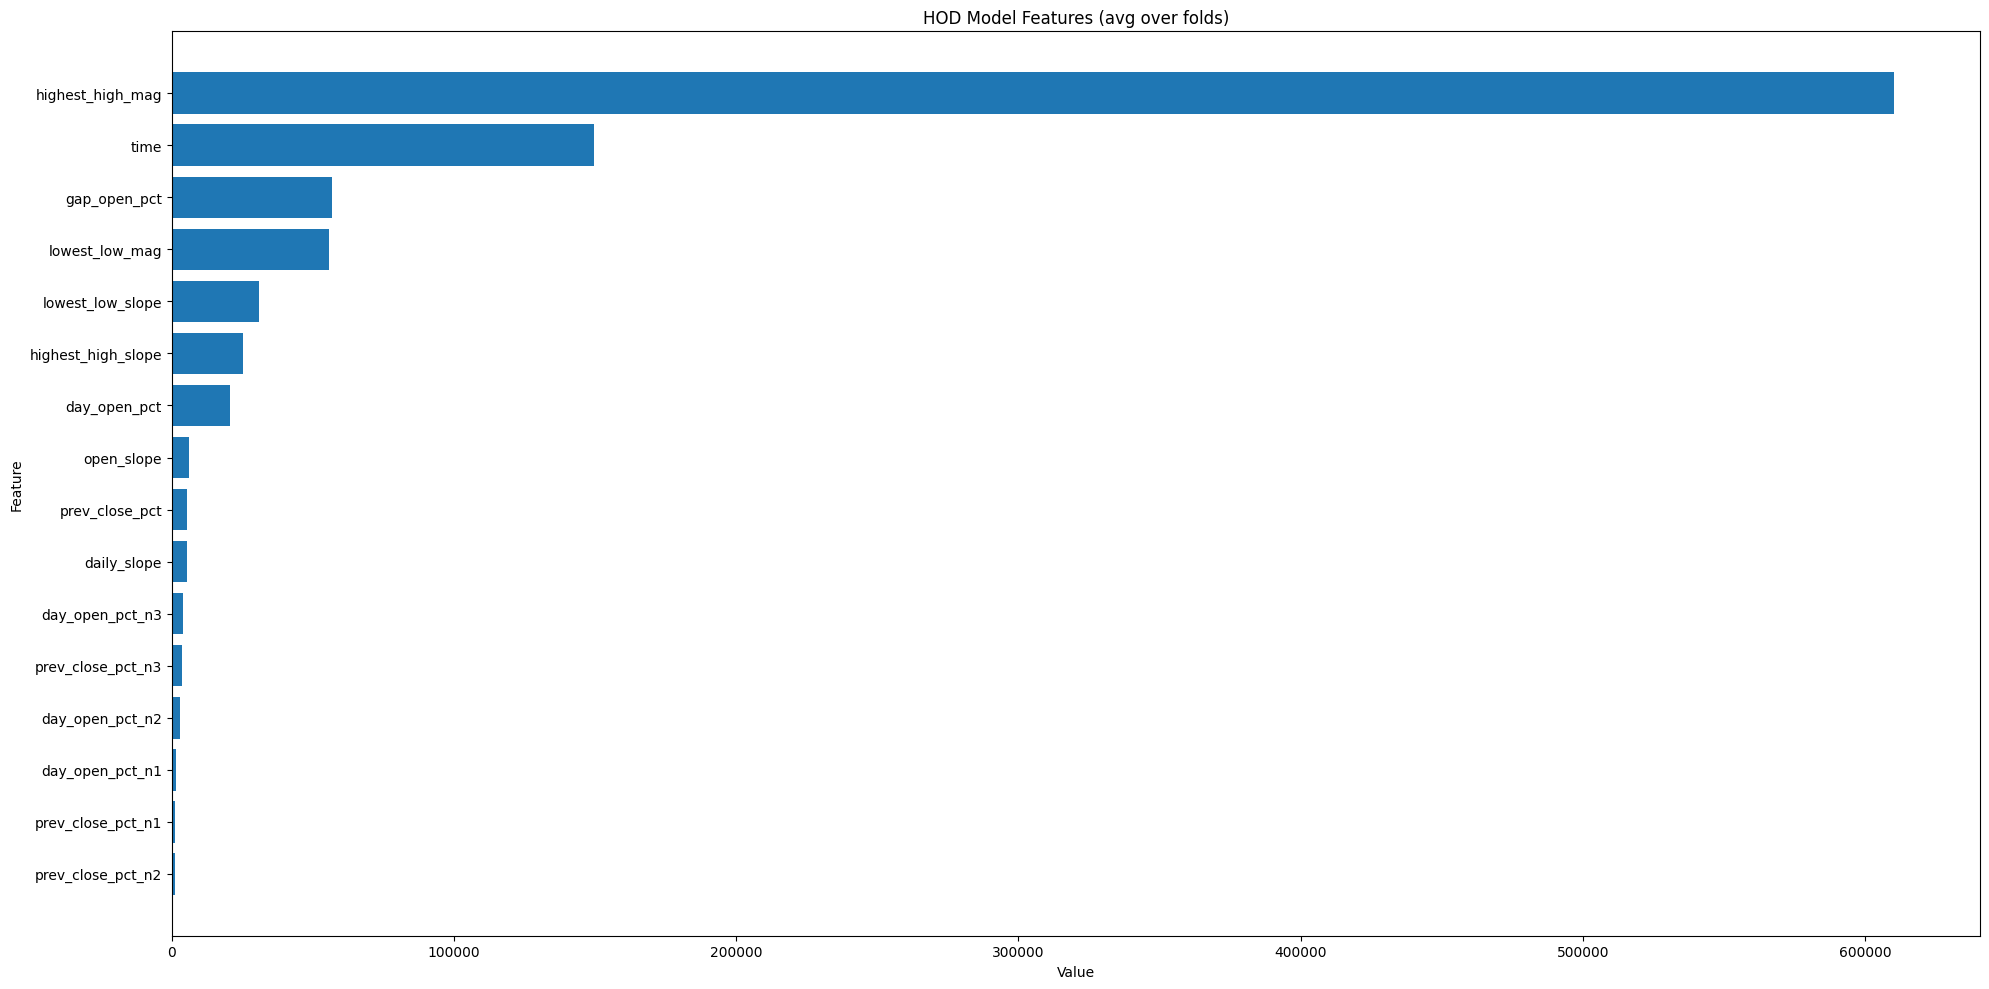

In [144]:
import mlflow
import matplotlib.pyplot as plt

booster = hod_model.named_steps['classifier'].booster_
importance_gain = booster.feature_importance(importance_type='gain')
feature_imp = pd.DataFrame(sorted(zip(importance_gain, X.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=True)

plt.figure(figsize=(20, 10))
plt.barh(feature_imp['Feature'], feature_imp['Value'])
plt.title('HOD Model Features (avg over folds)')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


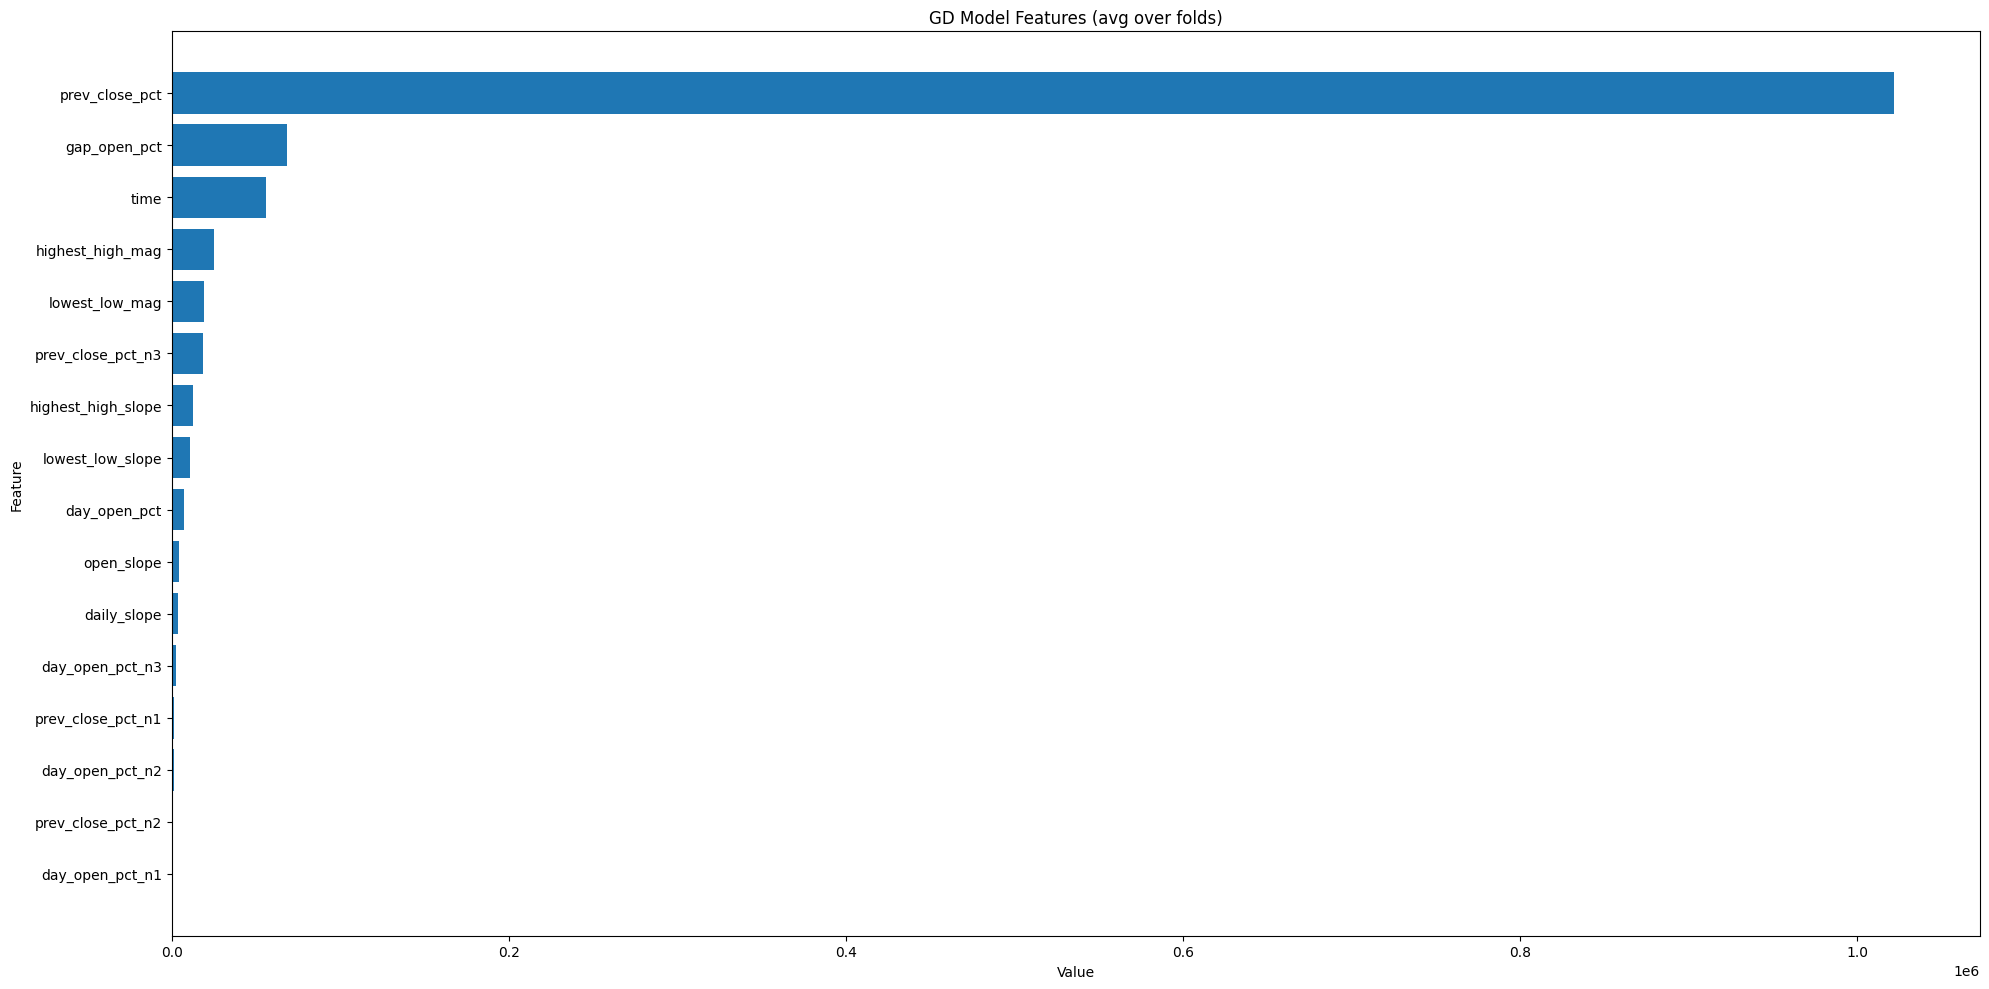

In [145]:
booster = gd_model.named_steps['classifier'].booster_
importance_gain = booster.feature_importance(importance_type='gain')
feature_imp = pd.DataFrame(sorted(zip(importance_gain, X.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=True)

plt.figure(figsize=(20, 10))
plt.barh(feature_imp['Feature'], feature_imp['Value'])
plt.title('GD Model Features (avg over folds)')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


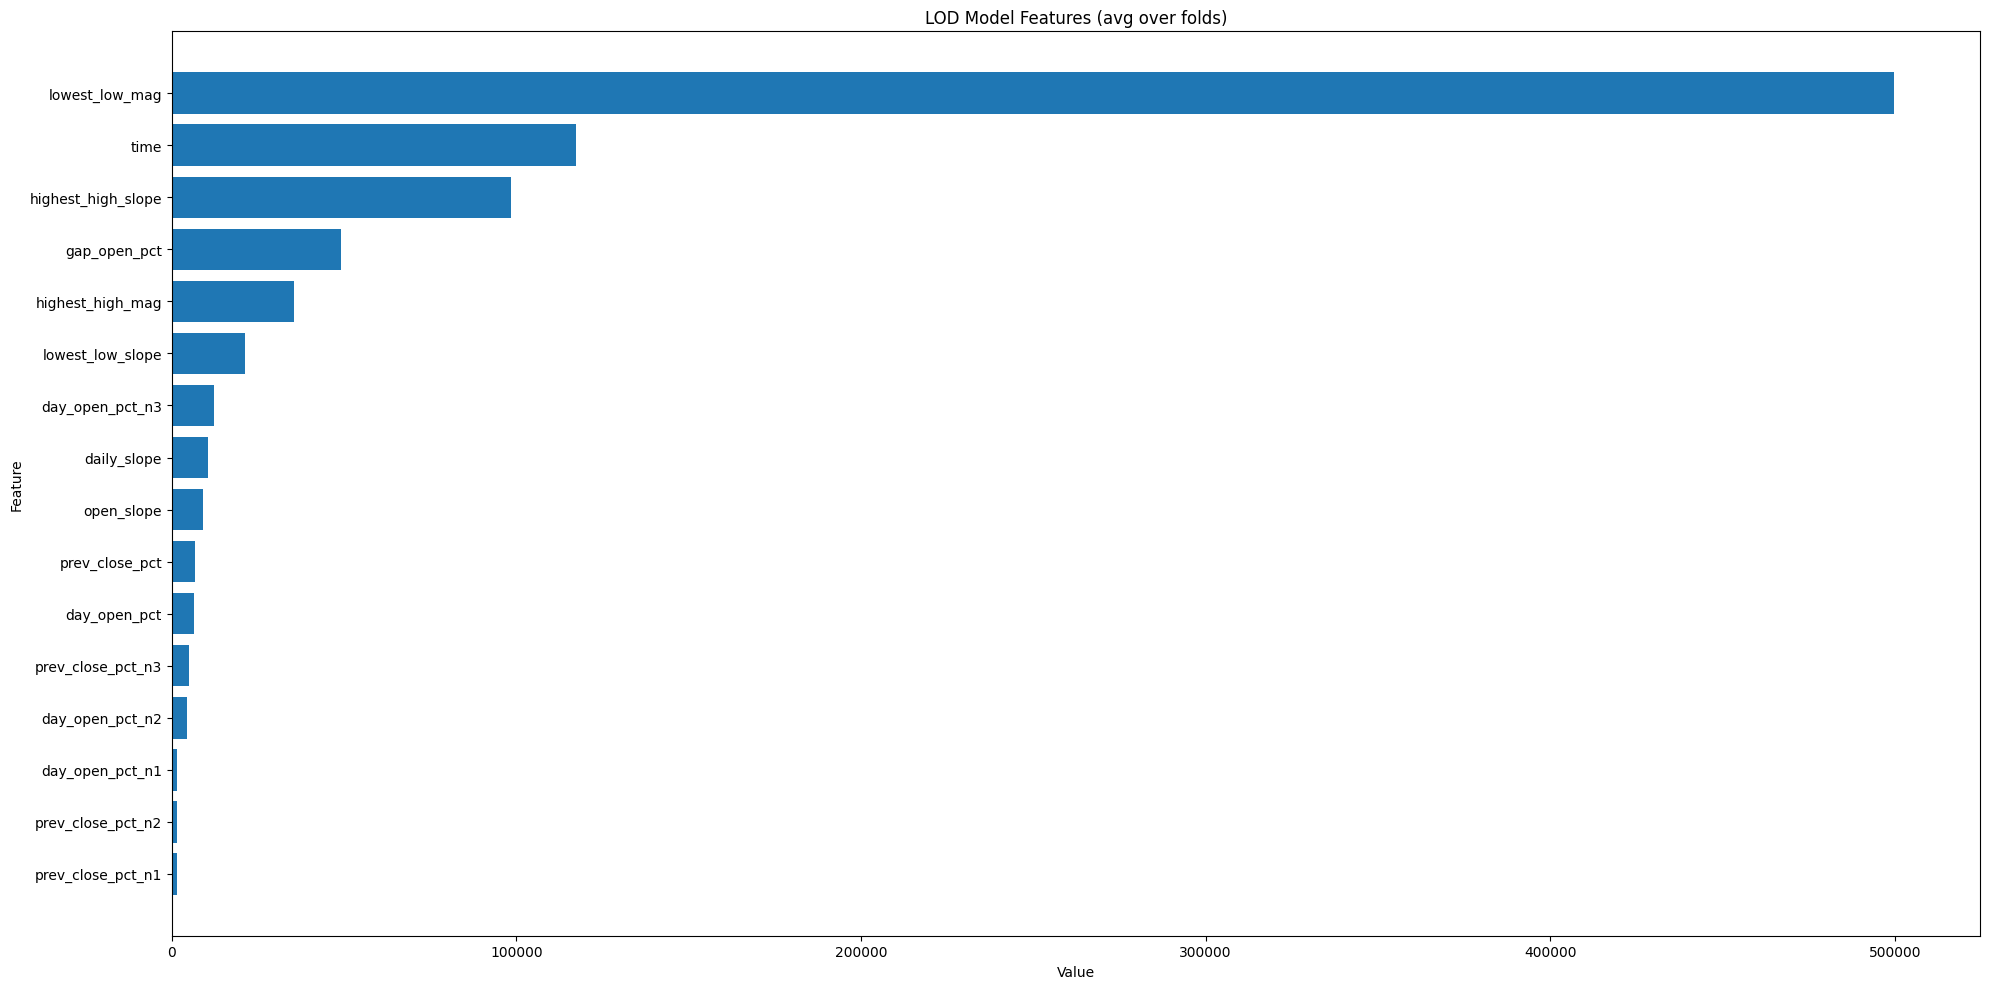

In [146]:
booster = lod_model.named_steps['classifier'].booster_
importance_gain = booster.feature_importance(importance_type='gain')
feature_imp = pd.DataFrame(sorted(zip(importance_gain, X.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=True)

plt.figure(figsize=(20, 10))
plt.barh(feature_imp['Feature'], feature_imp['Value'])
plt.title('LOD Model Features (avg over folds)')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Train/Test

In [147]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import mlflow

# Metrics for HOD model
y_pred_hod = hod_model.predict_proba(X_test)[:,-1]

roc_auc_hod = roc_auc_score(y_test['hod_in'], y_pred_hod)
precision_hod = precision_score(y_test['hod_in'], y_pred_hod > 0.5)
recall_hod = recall_score(y_test['hod_in'], y_pred_hod > 0.5)

print(f"ROC AUC Score: {roc_auc_hod}")
print(f"Precision Score: {precision_hod}")
print(f"Recall Score: {recall_hod}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} HOD Model {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(hod_model.named_steps))

    # Log the features
    mlflow.log_param("features", hod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_hod)
    mlflow.log_metric("precision", precision_hod)
    mlflow.log_metric("recall", recall_hod)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.9026037603833524
Precision Score: 0.8904747596153846
Recall Score: 0.8236520289049472
done.


In [148]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import mlflow

# Metrics for HOD model
y_pred_lod = lod_model.predict_proba(X_test)[:,-1]
roc_auc_lod = roc_auc_score(y_test['lod_in'], y_pred_lod)
precision_lod = precision_score(y_test['lod_in'], y_pred_lod > 0.5)
recall_lod = recall_score(y_test['lod_in'], y_pred_lod > 0.5)

print(f"ROC AUC Score: {roc_auc_lod}")
print(f"Precision Score: {precision_lod}")
print(f"Recall Score: {recall_lod}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} LOD Model {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(lod_model.named_steps))

    # Log the features
    mlflow.log_param("features", lod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_lod)
    mlflow.log_metric("precision", precision_lod)
    mlflow.log_metric("recall", recall_lod)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.907658156872509
Precision Score: 0.8761904761904762
Recall Score: 0.8710665552770815
done.


In [149]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import mlflow

# Metrics for HOD model
y_pred_gd = gd_model.predict_proba(X_test)[:,-1]

roc_auc_gd = roc_auc_score(y_test['green_day'], y_pred_gd)
precision_gd = precision_score(y_test['green_day'], y_pred_gd > 0.5)
recall_gd = recall_score(y_test['green_day'], y_pred_gd > 0.5)

print(f"ROC AUC Score: {roc_auc_gd}")
print(f"Precision Score: {precision_gd}")
print(f"Recall Score: {recall_gd}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} HOD Model {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(gd_model.named_steps))

    # Log the features
    mlflow.log_param("features", gd_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_gd)
    mlflow.log_metric("precision", precision_gd)
    mlflow.log_metric("recall", recall_gd)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.9511792044633466
Precision Score: 0.8529315427448412
Recall Score: 0.9188426252646437
done.


### CV

In [150]:
%%script false --no-raise-error

from sklearn.metrics import roc_auc_score, precision_score, recall_score
import mlflow
from sklearn.model_selection import TimeSeriesSplit

# Create 5 splits
tscv = TimeSeriesSplit(n_splits=10)

# Get the dates
dates = X.index.date

# Initialize lists to store scores for each split
roc_auc_scores = []
precision_scores = []
recall_scores = []

with mlflow.start_run():

    # Loop over the splits
    for train_index, test_index in tscv.split(dates):
        # Find the end of the last complete day in the test set
        last_day = np.unique(dates[test_index])[-2]  # -2 to get the second to last day
        test_index = test_index[dates[test_index] <= last_day]  # only keep days in test set up to the last complete day

        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_flags.iloc[train_index], y_flags.iloc[test_index]

        # Fit the model on the training data
        model = pipeline.fit(X_train, y_train['hod_in'])

        # Predict the test data
        y_pred = model.predict_proba(X_test)[:,-1]

        # Calculate the scores
        roc_auc = roc_auc_score(y_test['hod_in'], y_pred)
        precision = precision_score(y_test['hod_in'], y_pred > 0.5)
        recall = recall_score(y_test['hod_in'], y_pred > 0.5)

        # Store the scores
        roc_auc_scores.append(roc_auc)
        precision_scores.append(precision)
        recall_scores.append(recall)


    roc_auc_hod = np.mean(roc_auc_scores)
    precision_hod = np.mean(precision_scores)
    recall_hod = np.mean(recall_scores)

    # Print the average scores
    print(f"Average ROC AUC Score: {roc_auc_hod:.03} (+/- {np.std(roc_auc_scores):.02})")
    print(f"Average Precision Score: {precision_hod:.03} (+/- {np.std(precision_scores):.02})")
    print(f"Average Recall Score: {recall_hod:.03} (+/- {np.std(recall_scores):.02})")

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} HOD Model CV {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(hod_model.named_steps))

    # Log the features
    mlflow.log_param("features", hod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_hod)
    mlflow.log_metric("precision", precision_hod)
    mlflow.log_metric("recall", recall_hod)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

Couldn't find program: 'false'


In [151]:
%%script false --no-raise-error
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# Initialize lists to store scores for each split
roc_auc_scores = []
precision_scores = []
recall_scores = []

with mlflow.start_run():

    # Loop over the splits
    for train_index, test_index in tscv.split(dates):
        # Find the end of the last complete day in the test set
        last_day = np.unique(dates[test_index])[-2]  # -2 to get the second to last day
        test_index = test_index[dates[test_index] <= last_day]  # only keep days in test set up to the last complete day

        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_flags.iloc[train_index], y_flags.iloc[test_index]

        # Fit the model on the training data
        model = pipeline_lod.fit(X_train, y_train['lod_in'])

        # Predict the test data
        y_pred = model.predict_proba(X_test)[:,-1]

        # Calculate the scores
        roc_auc = roc_auc_score(y_test['lod_in'], y_pred)
        precision = precision_score(y_test['lod_in'], y_pred > 0.5)
        recall = recall_score(y_test['lod_in'], y_pred > 0.5)

        # Store the scores
        roc_auc_scores.append(roc_auc)
        precision_scores.append(precision)
        recall_scores.append(recall)


    roc_auc_lod = np.mean(roc_auc_scores)
    precision_lod = np.mean(precision_scores)
    recall_lod = np.mean(recall_scores)

    # Print the average scores
    print(f"Average ROC AUC Score: {roc_auc_hod:.03} (+/- {np.std(roc_auc_scores):.02})")
    print(f"Average Precision Score: {precision_hod:.03} (+/- {np.std(precision_scores):.02})")
    print(f"Average Recall Score: {recall_hod:.03} (+/- {np.std(recall_scores):.02})")

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} LOD Model CV {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(lod_model.named_steps))

    # Log the features
    mlflow.log_param("features", lod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_lod)
    mlflow.log_metric("precision", precision_lod)
    mlflow.log_metric("recall", recall_lod)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

Couldn't find program: 'false'


In [152]:
%%script false --no-raise-error
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# Initialize lists to store scores for each split
roc_auc_scores = []
precision_scores = []
recall_scores = []

with mlflow.start_run():

    # Loop over the splits
    for train_index, test_index in tscv.split(dates):
        # Find the end of the last complete day in the test set
        last_day = np.unique(dates[test_index])[-2]  # -2 to get the second to last day
        test_index = test_index[dates[test_index] <= last_day]  # only keep days in test set up to the last complete day

        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_flags.iloc[train_index], y_flags.iloc[test_index]

        # Fit the model on the training data
        model = pipeline_gd.fit(X_train, y_train['green_day'])

        # Predict the test data
        y_pred = model.predict_proba(X_test)[:,-1]

        # Calculate the scores
        roc_auc = roc_auc_score(y_test['green_day'], y_pred)
        precision = precision_score(y_test['green_day'], y_pred > 0.5)
        recall = recall_score(y_test['green_day'], y_pred > 0.5)

        # Store the scores
        roc_auc_scores.append(roc_auc)
        precision_scores.append(precision)
        recall_scores.append(recall)


    roc_auc_gd = np.mean(roc_auc_scores)
    precision_gd = np.mean(precision_scores)
    recall_gd = np.mean(recall_scores)

    # Print the average scores
    print(f"Average ROC AUC Score: {roc_auc_hod:.03} (+/- {np.std(roc_auc_scores):.02})")
    print(f"Average Precision Score: {precision_hod:.03} (+/- {np.std(precision_scores):.02})")
    print(f"Average Recall Score: {recall_hod:.03} (+/- {np.std(recall_scores):.02})")

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} GD Model CV {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(gd_model.named_steps))

    # Log the features
    mlflow.log_param("features", gd_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_gd)
    mlflow.log_metric("precision", precision_gd)
    mlflow.log_metric("recall", recall_gd)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

Couldn't find program: 'false'


In [153]:
# feature_names = pipeline.feature_names_in_
# coefficients = pipeline.named_steps['classifier'].feature_importances_
# # coefficients = pipeline.named_steps['classifier'].coef_[0]
# for feature, coef in zip(feature_names, coefficients):
#     print(f"{feature}: {coef}")

In [154]:
import datetime
import plotly.express as px


time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'hod_in'].copy()

    y_pred_val = pipeline.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (HOD Model)')
fig.show()

In [155]:
import datetime
import plotly.express as px

time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'lod_in'].copy()

    y_pred_val = pipeline_lod.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (LOD Model)')
fig.show()

In [156]:
import datetime
import plotly.express as px

time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'green_day'].copy()

    y_pred_val = pipeline_gd.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (GD Model)')
fig.show()

In [157]:
df_results = X_test.copy()
df_results['pred_hod'] = y_pred_hod
df_results['pred_lod'] = y_pred_lod
df_results['pred_gd'] = y_pred_gd

In [158]:
X_test.index[0]

Timestamp('2023-05-31 09:45:00')

In [159]:
import plotly.graph_objects as go

# Pick a day in the test set
# test_day = '2023-12-21'
test_day = '2023-12-28'
test_df = df_results.loc[test_day:test_day]
X_prices = spx_data.loc[test_day:test_day, ['open','high','low','close']]

df_viz = test_df.merge(X_prices, left_index=True, right_index=True)

fig = go.Figure(data=[go.Candlestick(x=df_viz.index,
                open=df_viz['open'],
                high=df_viz['high'],
                low=df_viz['low'],
                close=df_viz['close'])])

fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_hod'].ewm(2).mean(), mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_hod'], mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_lod'].ewm(3).mean(), mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#3399cc')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_gd'].ewm(3).mean(), mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#98ff98')))

fig.add_shape(
    type="line",
    x0=df_viz.index.min(),
    x1=df_viz.index.max(),
    y0=0.5,
    y1=0.5,
    yref='y2',
    line=dict(
        color="Red",
        width=1.5,
        dash="dash",
    )
)

fig.update_layout(
    template='plotly_dark',
    yaxis=dict(
        tickformat='.0f'
    ),
    yaxis2=dict(
        overlaying='y',
        side='right',
        tickformat=".0%"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    title='OHLC vs Prediction Over Time',
    xaxis_rangeslider_visible=False
)

fig.show()

# Inference Pipeline

In [160]:
# Get data
import yfinance as yf
import numpy as np
import pandas as pd
import datetime

# Create a list of times from 9:30 to 15:55 with 5 minute intervals
times = pd.date_range(start="9:30", end="15:55", freq='5min').time

# Create a dictionary that maps each time to a unique integer
time_to_int = {time: i+1 for i, time in enumerate(times)}


def create_features(ticker_str):
    '''
    Function to create dataframe of features for top/bottom model.
    '''
    ticker = yf.Ticker(ticker_str)
    df = ticker.history(period='5d',interval='5m')
    df = df.loc[
        (df.index.time >= datetime.time(9,30)) &\
        (df.index.time < datetime.time(16,0)),
    ['Open','High','Low','Close']]
    df.columns = ['open','high','low','close']

    df['time'] = df.index.time
    df['eod_close'] = df.groupby(df.index.date)['close'].tail(1)
    df['prev_close'] = df['eod_close'].shift(1)
    df['prev_close'] = df['prev_close'].ffill()
    df['eod_close'] = df['eod_close'].bfill()
    df['green_day'] = df['eod_close'] > df['prev_close']

    # Assume df is your DataFrame and 'time' is your column of times
    df['bar_num'] = df['time'].map(time_to_int)

    df['eod_close_pts'] = df['eod_close'] - df['prev_close']
    df['eod_close_pct'] = df['eod_close_pts'] / df['prev_close']

    for day in sorted(set(df.index.date)):
        day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
        day_open = df.loc[day_str, 'open'].iloc[0]
        df.loc[day_str, 'lod'] = df.loc[day_str, 'low'].min()
        df.loc[day_str, 'label_lod'] = (df.loc[day_str, 'low'] == df.loc[day_str, 'lod']).astype(int)
        
        df.loc[day_str, 'hod'] = df.loc[day_str, 'high'].max()
        df.loc[day_str, 'label'] = (df.loc[day_str, 'high'] == df.loc[day_str, 'hod']).astype(int)
        df.loc[day_str, 'day_open'] = day_open
        df.loc[day_str, 'day_open_pts'] = df.loc[day_str, 'close'] - df.loc[day_str, 'day_open']
        df.loc[day_str, 'day_open_pct'] = df.loc[day_str, 'day_open_pts'] / df.loc[day_str, 'day_open']
        df.loc[day_str, 'prev_close_pts'] = df.loc[day_str, 'close'] - df.loc[day_str, 'prev_close']
        df.loc[day_str, 'prev_close_pct'] = df.loc[day_str, 'prev_close_pts'] / df.loc[day_str, 'prev_close']

        # Lowest low
        df.loc[day_str, 'lowest_low'] = df.loc[day_str, 'low'].expanding().min()
        df.loc[day_str, 'lowest_low'] = df.loc[day_str, 'lowest_low'].shift(1)
        df.loc[day_str, 'lowest_low'] = df.loc[day_str, 'lowest_low'].ffill()
        df.loc[day_str, 'lowest_low_mag'] = (df.loc[day_str, 'close'] / df.loc[day_str, 'lowest_low']) - 1

        # Highest high
        df.loc[day_str, 'highest_high'] = df.loc[day_str, 'high'].expanding().max()
        df.loc[day_str, 'highest_high'] = df.loc[day_str, 'highest_high'].shift(1)
        df.loc[day_str, 'highest_high'] = df.loc[day_str, 'highest_high'].ffill()
        df.loc[day_str, 'highest_high_mag'] = (df.loc[day_str, 'close'] / df.loc[day_str, 'highest_high']) - 1

        # Shifted
        df.loc[day_str, 'prev_close_pct_n1'] = df.loc[day_str, 'prev_close_pct'].shift(1)
        df.loc[day_str, 'prev_close_pct_n2'] = df.loc[day_str, 'prev_close_pct'].shift(2)
        df.loc[day_str, 'prev_close_pct_n3'] = df.loc[day_str, 'prev_close_pct'].shift(3)

        df.loc[day_str, 'day_open_pct_n1'] = df.loc[day_str, 'day_open_pct'].shift(1)
        df.loc[day_str, 'day_open_pct_n2'] = df.loc[day_str, 'day_open_pct'].shift(2)
        df.loc[day_str, 'day_open_pct_n3'] = df.loc[day_str, 'day_open_pct'].shift(3)

        # New Features
        df.loc[day_str, 'open_slope'] = df.loc[day_str, 'day_open_pct'] / df.loc[day_str, 'bar_num']
        df.loc[day_str, 'daily_slope'] = df.loc[day_str, 'prev_close_pct'] / df.loc[day_str, 'bar_num']

        df.loc[day_str, 'highest_high_slope'] = (df.loc[day_str, 'close'] - df.loc[day_str, 'highest_high']) / df.loc[day_str, 'bar_num']
        df.loc[day_str, 'lowest_low_slope'] = (df.loc[day_str, 'close'] - df.loc[day_str, 'lowest_low']) / df.loc[day_str, 'bar_num']
    
        
    df['gap_open'] = df['day_open'] - df['prev_close']
    df['gap_open_pct'] = df['gap_open'] / df['prev_close']
    df = df.dropna(subset=[
        'prev_close_pct',
        'gap_open_pct',
        'day_open_pct_n3',
        'prev_close_pct_n3'
    ])
    df = df.loc[(df['time'] < datetime.time(16,0)) & (df['time'] >= datetime.time(9,45))]
    return df

In [161]:
import joblib

df_feats = create_features(tck)

In [162]:

hod_model1 = joblib.load(ticker_dict[tck]['hod_model'])
lod_model1 = joblib.load(ticker_dict[tck]['lod_model'])
gd_model1 = joblib.load(ticker_dict[tck]['gd_model'])

def create_preds_df(df_feats):
    predicted_proba_hod = hod_model1.predict_proba(df_feats)[:,-1]
    predicted_proba_lod = lod_model1.predict_proba(df_feats)[:,-1]
    predicted_proba_gd = gd_model1.predict_proba(df_feats)[:,-1]
    df_viz = df_feats.copy()
    df_viz['pred_hod'] = predicted_proba_hod
    df_viz['pred_lod'] = predicted_proba_lod
    df_viz['pred_gd'] = predicted_proba_gd
    return df_viz

df_viz = create_preds_df(df_feats)

In [163]:
# Create df for visual
def create_viz(df_viz, date_str):

    df_use = df_viz.loc[date_str:date_str]
    
    fig = go.Figure(data=[go.Candlestick(x=df_use.index,
                open=df_use['open'],
                high=df_use['high'],
                low=df_use['low'],
                close=df_use['close'])])

    fig.add_trace(go.Scatter(x=df_use.index, y=df_use['pred_hod'], mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
    fig.add_trace(go.Scatter(x=df_use.index, y=df_use['pred_lod'], mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#3399cc')))
    fig.add_trace(go.Scatter(x=df_use.index, y=df_use['pred_gd'], mode='lines', name='pred_gd', yaxis='y2', line=dict(color='#9400d3')))


    fig.add_shape(
        type="line",
        x0=df_use.index.min(),
        x1=df_use.index.max(),
        y0=0.5,
        y1=0.5,
        yref='y2',
        line=dict(
            color="Red",
            width=1.5,
            dash="dash",
        )
    )

    max_high = df_use['high'].max()
    max_high_time = df_use['high'].idxmax()

    min_low = df_use['low'].min()
    min_low_time = df_use['low'].idxmin()

    fig.add_annotation(
        x=max_high_time,
        y=max_high,
        text=f"{str(int(max_high))}",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="#ffffff"
        ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=1,
        borderpad=1,
        bgcolor="#ff5f5f",
        opacity=0.8
    )

    fig.add_annotation(
        x=min_low_time,
        y=min_low,
        text=f"{str(int(min_low))}",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="#ffffff"
        ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=30,  # Adjust the y offset for the annotation
        bordercolor="#c7c7c7",
        borderwidth=1,
        borderpad=1,
        bgcolor="#3399cc",
        opacity=0.8
    )

    fig.update_layout(
        template='plotly_dark',
        yaxis=dict(
            tickformat='.0f'
        ),
        yaxis2=dict(
            overlaying='y',
            side='right',
            tickformat=".0%"
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        title='OHLC vs Prediction Over Time',
        xaxis_rangeslider_visible=False
    )

    fig.show()
    

In [164]:
df_viz

,open,high,low,close,time,eod_close,prev_close,green_day,bar_num,eod_close_pts,...,day_open_pct_n3,open_slope,daily_slope,highest_high_slope,lowest_low_slope,gap_open,gap_open_pct,pred_hod,pred_lod,pred_gd
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-09 09:45:00-05:00,1959.977417,1960.147095,1957.631592,1958.394165,09:45:00,1967.885742,1988.681030,False,4,-20.795288,...,-0.000476,-0.000805,-0.003807,-1.626740,-0.383789,-23.956543,-0.012046,0.430295,0.054760,0.030998
2024-01-09 09:50:00-05:00,1958.395508,1959.431885,1957.414551,1959.431885,09:50:00,1967.885742,1988.681030,False,5,-20.795288,...,-0.001422,-0.000539,-0.002942,-1.093848,0.360059,-23.956543,-0.012046,0.305036,0.182564,0.043515
2024-01-09 09:55:00-05:00,1959.478027,1961.316650,1959.431641,1961.316650,09:55:00,1967.885742,1988.681030,False,6,-20.795288,...,-0.002441,-0.000289,-0.002293,-0.597412,0.650350,-23.956543,-0.012046,0.223328,0.352842,0.067413
2024-01-09 10:00:00-05:00,1961.418945,1961.805786,1960.467896,1960.467896,10:00:00,1967.885742,1988.681030,False,7,-20.795288,...,-0.003222,-0.000310,-0.002027,-0.633318,0.436192,-23.956543,-0.012046,0.242469,0.336713,0.043769
2024-01-09 10:05:00-05:00,1960.052856,1961.015259,1959.147339,1960.972534,10:05:00,1967.885742,1988.681030,False,8,-20.795288,...,-0.002694,-0.000239,-0.001742,-0.491074,0.444748,-23.956543,-0.012046,0.233572,0.370810,0.054705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12 15:35:00-05:00,1949.224243,1949.542969,1949.118896,1949.401489,15:35:00,1950.992554,1955.437256,False,74,-4.444702,...,-0.015344,-0.000195,-0.000042,-0.465040,0.025757,22.442627,0.011477,0.996599,0.563796,0.075191
2024-01-12 15:40:00-05:00,1949.388184,1949.453003,1948.853394,1949.453003,15:40:00,1950.992554,1955.437256,False,75,-4.444702,...,-0.014833,-0.000192,-0.000041,-0.458153,0.026100,22.442627,0.011477,0.997402,0.625440,0.070455
2024-01-12 15:45:00-05:00,1949.470825,1950.212891,1949.470825,1950.212891,15:45:00,1950.992554,1955.437256,False,76,-4.444702,...,-0.014488,-0.000184,-0.000035,-0.442126,0.035755,22.442627,0.011477,0.997331,0.745244,0.079786


In [165]:
create_viz(df_viz, '2024-01-10')

In [166]:
XXX

NameError: name 'XXX' is not defined